# Textract with HF-FLAN-T5 model for text2text generation

In [3]:
import json
import boto3
from IPython.display import Image, display
from IPython.display import IFrame

Let's put in some example input text. You can put any text containing the task, the model returns the output of the accomplished task.

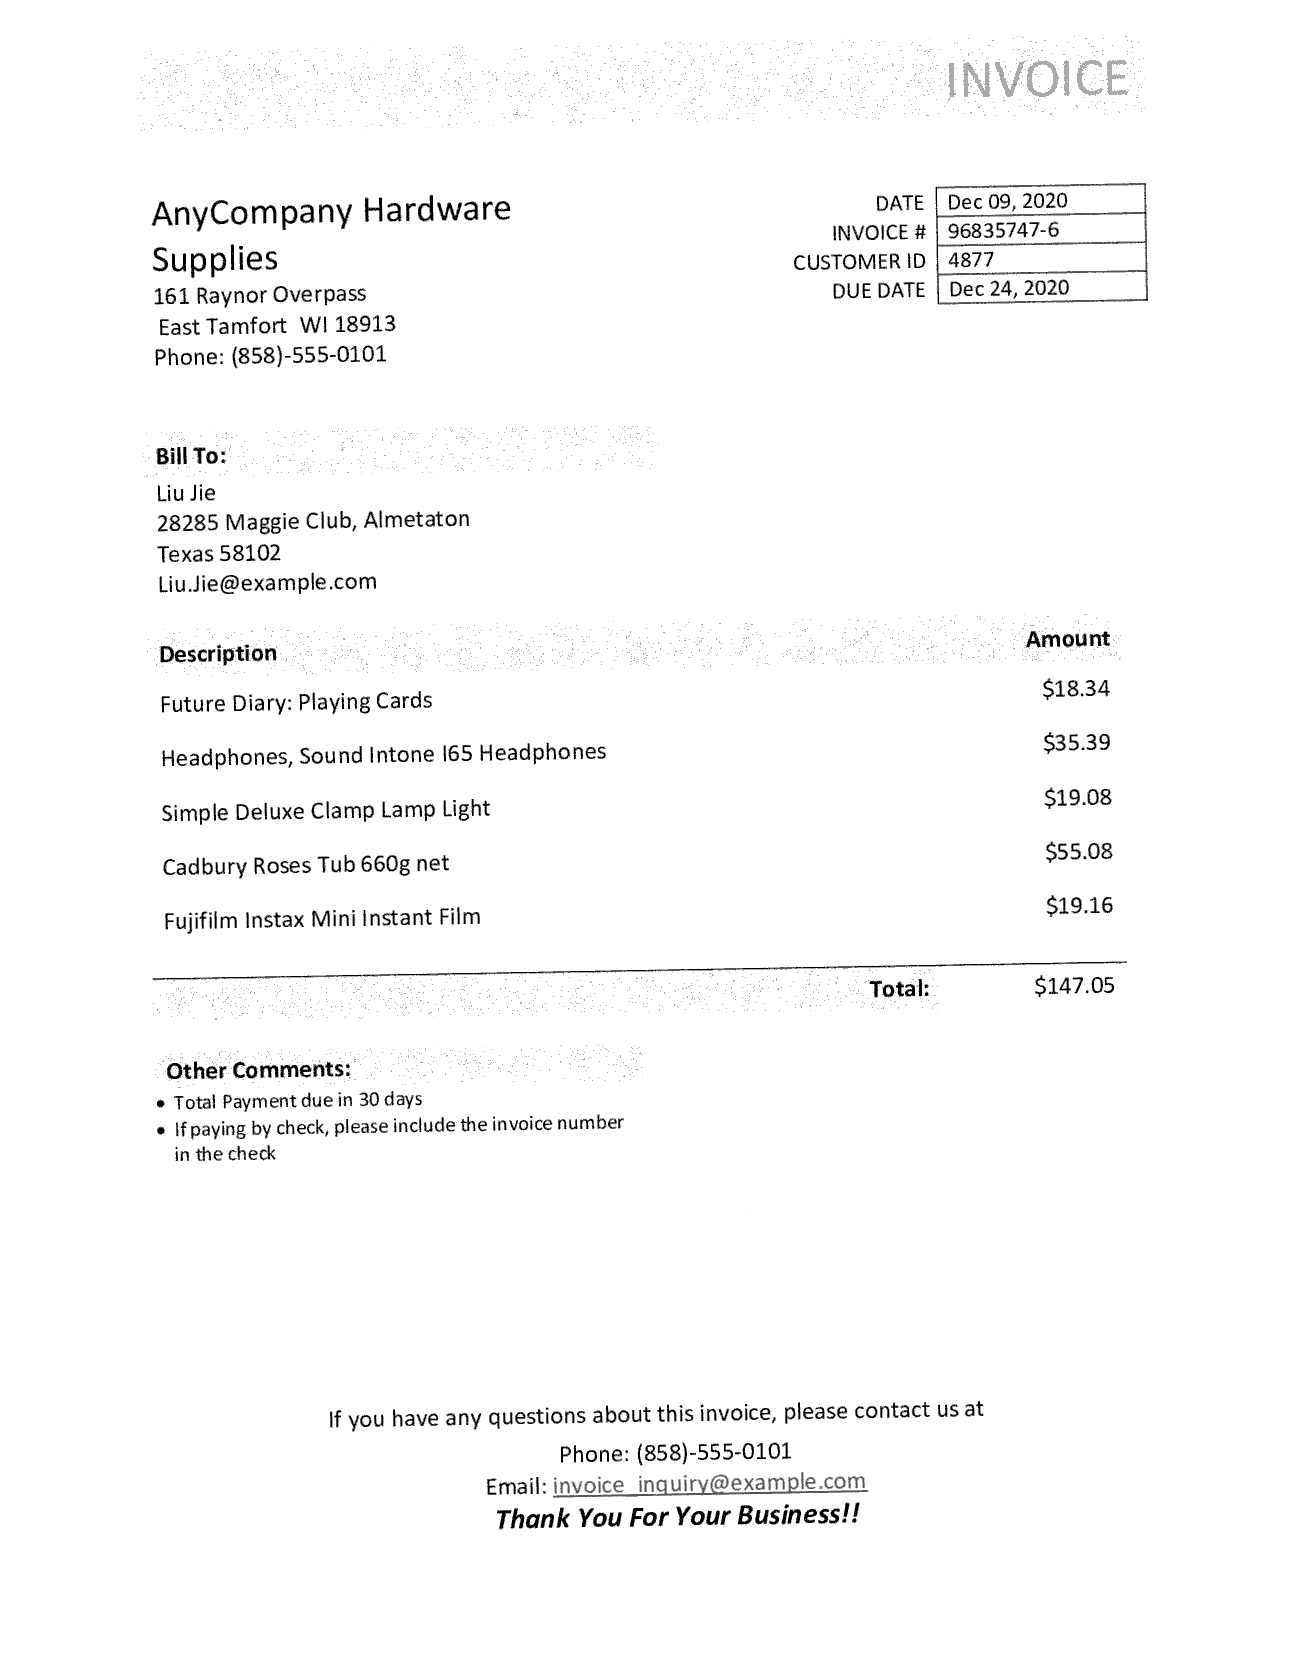

In [4]:
# Document
documentName = "document_7.png"
display(Image(filename=documentName))

In [5]:
# Amazon Textract client
textract = boto3.client('textract')

# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})
text = []
# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text.append(item["Text"])
textract_text = "\n".join(text)


In [6]:
print(textract_text)

INVOICE
AnyCompany Hardware
DATE
Dec 09, 2020
INVOICE #
96835747-6
Supplies
CUSTOMER ID
4877
161 Raynor Overpass
DUE DATE
Dec 24, 2020
East Tamfort WI 18913
Phone: (858)-555-0101
Bill To:
Liu Jie
28285 Maggie Club, Almetaton
Texas 58102
Liu.Jie@example.com
Amount
Description
Future Diary: Playing Cards
$18.34
Headphones, Sound Intone 165 Headphones
$35.39
Simple Deluxe Clamp Lamp Light
$19.08
Cadbury Roses Tub 660g net
$55.08
Fujifilm Instax Mini Instant Film
$19.16
Total:
$147.05
Other Comments:
Total Payment due in 30 days
If paying by check, please include the invoice number
in the check
If you have any questions about this invoice, please contact us at
Phone: (858)-555-0101
Email: invoice inquiry@example.com
Thank You For Your Business!!


In [24]:
prompt_text = "Given the following text, what is the document date? %s"%(textract_text)

print(prompt_text)

Given the following text, what is the document date? INVOICE
AnyCompany Hardware
DATE
Dec 09, 2020
INVOICE #
96835747-6
Supplies
CUSTOMER ID
4877
161 Raynor Overpass
DUE DATE
Dec 24, 2020
East Tamfort WI 18913
Phone: (858)-555-0101
Bill To:
Liu Jie
28285 Maggie Club, Almetaton
Texas 58102
Liu.Jie@example.com
Amount
Description
Future Diary: Playing Cards
$18.34
Headphones, Sound Intone 165 Headphones
$35.39
Simple Deluxe Clamp Lamp Light
$19.08
Cadbury Roses Tub 660g net
$55.08
Fujifilm Instax Mini Instant Film
$19.16
Total:
$147.05
Other Comments:
Total Payment due in 30 days
If paying by check, please include the invoice number
in the check
If you have any questions about this invoice, please contact us at
Phone: (858)-555-0101
Email: invoice inquiry@example.com
Thank You For Your Business!!


### Query endpoint that you have created

In [25]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'
#endpoint_name = 'jumpstart-dft-hf-text2text-flan-t5-xxl'
endpoint_name = 'jumpstart-example-huggingface-text2text-2023-04-24-19-05-48-306'
def query_endpoint(encoded_text):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-text', Body=encoded_text)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response['Body'].read())
    generated_text = model_predictions['generated_text']
    return generated_text

for text in [prompt_text]:
    query_response = query_endpoint(json.dumps(text).encode('utf-8'))
    generated_text = parse_response(query_response)
    # print (f"Inference:{newline}"
    #         f"input text: {text}{newline}"
    print(f"generated text: {bold}{generated_text}{unbold}{newline}")

generated text: 09, 2020



### Advanced features

***
This model also supports many advanced parameters while performing inference. They include:

* **max_length:** Model generates text until the output length (which includes the input context length) reaches `max_length`. If specified, it must be a positive integer.
* **num_return_sequences:** Number of output sequences returned. If specified, it must be a positive integer.
* **num_beams:** Number of beams used in the greedy search. If specified, it must be integer greater than or equal to `num_return_sequences`.
* **no_repeat_ngram_size:** Model ensures that a sequence of words of `no_repeat_ngram_size` is not repeated in the output sequence. If specified, it must be a positive integer greater than 1.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **early_stopping:** If True, text generation is finished when all beam hypotheses reach the end of stence token. If specified, it must be boolean.
* **do_sample:** If True, sample the next word as per the likelyhood. If specified, it must be boolean.
* **top_k:** In each step of text generation, sample from only the `top_k` most likely words. If specified, it must be a positive integer.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **seed:** Fix the randomized state for reproducibility. If specified, it must be an integer.

We may specify any subset of the parameters mentioned above while invoking an endpoint. Next, we show an example of how to invoke endpoint with these arguments

***

In [26]:
#Input must be a json
payload = {"text_inputs":prompt_text, "max_length":300}

def query_endpoint_with_json_payload(encoded_json):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=encoded_json)
    return response

query_response = query_endpoint_with_json_payload(json.dumps(payload).encode('utf-8'))

def parse_response_multiple_texts(query_response):
    model_predictions = json.loads(query_response['Body'].read())
    generated_text = model_predictions['generated_texts']
    return generated_text

generated_texts = parse_response_multiple_texts(query_response)
print(generated_texts)

['Dec 09, 2020']


## With Comprehend PII

In [27]:
import boto3
 
client = boto3.client('comprehend')

In [28]:
response = client.detect_pii_entities(
    Text= textract_text,
    LanguageCode='en'
)
print(response)

{'Entities': [{'Score': 0.9998617768287659, 'Type': 'DATE_TIME', 'BeginOffset': 33, 'EndOffset': 45}, {'Score': 0.9894557595252991, 'Type': 'NAME', 'BeginOffset': 97, 'EndOffset': 103}, {'Score': 0.999476432800293, 'Type': 'DATE_TIME', 'BeginOffset': 122, 'EndOffset': 134}, {'Score': 0.998137354850769, 'Type': 'ADDRESS', 'BeginOffset': 135, 'EndOffset': 156}, {'Score': 0.9999165534973145, 'Type': 'PHONE', 'BeginOffset': 164, 'EndOffset': 178}, {'Score': 0.9998140931129456, 'Type': 'NAME', 'BeginOffset': 188, 'EndOffset': 195}, {'Score': 0.8498421907424927, 'Type': 'ADDRESS', 'BeginOffset': 196, 'EndOffset': 236}, {'Score': 0.9981164932250977, 'Type': 'EMAIL', 'BeginOffset': 237, 'EndOffset': 256}, {'Score': 0.9999027848243713, 'Type': 'PHONE', 'BeginOffset': 672, 'EndOffset': 686}, {'Score': 0.9639142155647278, 'Type': 'EMAIL', 'BeginOffset': 694, 'EndOffset': 701}, {'Score': 0.9995414018630981, 'Type': 'EMAIL', 'BeginOffset': 702, 'EndOffset': 721}], 'ResponseMetadata': {'RequestId': 

In [29]:
comprehend_txt = textract_text
 
# reversed to not modify the offsets of other entities when substituting
print("Detected Entities: ")
for entity in reversed(response['Entities']):
    print(entity['Type'] )
    comprehend_txt  = textract_text[:entity['BeginOffset']] + entity['Type'] + comprehend_txt[entity['EndOffset']:]
 


Detected Entities: 
EMAIL
EMAIL
PHONE
EMAIL
ADDRESS
NAME
PHONE
ADDRESS
DATE_TIME
NAME
DATE_TIME


In [30]:
print(comprehend_txt)

INVOICE
AnyCompany Hardware
DATE
DATE_TIME
INVOICE #
96835747-6
Supplies
CUSTOMER ID
4877
161 NAME Overpass
DUE DATE
DATE_TIME
ADDRESS
Phone: PHONE
Bill To:
NAME
ADDRESS
EMAIL
Amount
Description
Future Diary: Playing Cards
$18.34
Headphones, Sound Intone 165 Headphones
$35.39
Simple Deluxe Clamp Lamp Light
$19.08
Cadbury Roses Tub 660g net
$55.08
Fujifilm Instax Mini Instant Film
$19.16
Total:
$147.05
Other Comments:
Total Payment due in 30 days
If paying by check, please include the invoice number
in the check
If you have any questions about this invoice, please contact us at
Phone: PHONE
Email: EMAIL EMAIL
Thank You For Your Business!!


In [33]:
prompt_text = "Given the following text, what is the document date? %s"%(comprehend_txt)

print(prompt_text)

Given the following text, what is the document date? INVOICE
AnyCompany Hardware
DATE
DATE_TIME
INVOICE #
96835747-6
Supplies
CUSTOMER ID
4877
161 NAME Overpass
DUE DATE
DATE_TIME
ADDRESS
Phone: PHONE
Bill To:
NAME
ADDRESS
EMAIL
Amount
Description
Future Diary: Playing Cards
$18.34
Headphones, Sound Intone 165 Headphones
$35.39
Simple Deluxe Clamp Lamp Light
$19.08
Cadbury Roses Tub 660g net
$55.08
Fujifilm Instax Mini Instant Film
$19.16
Total:
$147.05
Other Comments:
Total Payment due in 30 days
If paying by check, please include the invoice number
in the check
If you have any questions about this invoice, please contact us at
Phone: PHONE
Email: EMAIL EMAIL
Thank You For Your Business!!


In [34]:
#Input must be a json
payload = {"text_inputs":prompt_text, "max_length":300}

def query_endpoint_with_json_payload(encoded_json):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=encoded_json)
    return response

query_response = query_endpoint_with_json_payload(json.dumps(payload).encode('utf-8'))

def parse_response_multiple_texts(query_response):
    model_predictions = json.loads(query_response['Body'].read())
    generated_text = model_predictions['generated_texts']
    return generated_text

generated_texts = parse_response_multiple_texts(query_response)
print(generated_texts)

['96835747-6']
